In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

/kaggle/input/severstal-steel-defect-detection/sample_submission.csv
/kaggle/input/severstal-steel-defect-detection/train_images/f1bd3a48a.jpg
/kaggle/input/severstal-steel-defect-detection/test_images/6d2a4005f.jpg


In [ ]:
!pip install ultralytics -q

In [ ]:
DATASET_PATH = os.path.join("/kaggle/input", "severstal-steel-defect-detection")
TRAIN_IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "train_images")
TEST_IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "test_images")

init_dir=os.getcwd()

In [ ]:
import glob

train_img_names = sorted(glob.glob(TRAIN_IMAGE_DATASET_PATH +'/' + "*.jpg"))
test_img_names = sorted(glob.glob(TEST_IMAGE_DATASET_PATH +'/' + "*.jpg"))
print(len(train_img_names))
print(len(test_img_names))

12568
5506


In [ ]:
train_df_b = pd.read_csv(DATASET_PATH+"/train.csv")
train_df_b['ClassId'] = train_df_b['ClassId'].astype(int)

In [ ]:
#train_df_b["ClassId"].value_counts().plot(kind = 'bar')
#train_df_b.groupby(['ClassId'])['ClassId'].count()
train_df_b["ClassId"].value_counts()

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

In [ ]:
#train_df_b.groupby(['ClassId'])['ClassId'].count().sum()
train_df_b["ClassId"].value_counts().sum()

7095

In [ ]:
train_df_b['ImageId'].nunique()

6666

In [ ]:
#train_df_b.groupby(['ImageId'])['ImageId'].count().max()
train_df_b["ImageId"].value_counts().max()

3

In [ ]:
train_df_b.groupby(['ImageId'])['ImageId'].filter(lambda x: len(x) > 1).count()

856

In [ ]:
train_df_b.groupby(['ImageId'])['ImageId'].filter(lambda x: len(x) > 2)

6101    db4867ee8.jpg
6102    db4867ee8.jpg
6103    db4867ee8.jpg
6650    ef24da2ba.jpg
6651    ef24da2ba.jpg
6652    ef24da2ba.jpg
Name: ImageId, dtype: object

In [ ]:
train_df_b.loc[train_df_b['ImageId'].isin(['db4867ee8.jpg'])]

,ImageId,ClassId,EncodedPixels
6101,db4867ee8.jpg,1,349941 2 350194 6 350447 11 350700 15 350953 1...
6102,db4867ee8.jpg,2,354411 17 354634 50 354857 82 355096 99 355351...
6103,db4867ee8.jpg,3,233729 3008 236801 64


In [ ]:
train_df_b.groupby(['ImageId','ClassId'])['ImageId'].count().max()

1

In [ ]:
train_df = train_df_b.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
train_df['count'] = train_df.count(axis=1)
train_df

ClassId,1,2,3,4,count
ImageId,,,,,
0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,NaN,NaN,NaN,1
0007a71bf.jpg,NaN,NaN,18661 28 18863 82 19091 110 19347 110 19603 11...,NaN,1
000a4bcdd.jpg,37607 3 37858 8 38108 14 38359 20 38610 25 388...,NaN,NaN,NaN,1
000f6bf48.jpg,NaN,NaN,NaN,131973 1 132228 4 132483 6 132738 8 132993 11 ...,1
0014fce06.jpg,NaN,NaN,229501 11 229741 33 229981 55 230221 77 230468...,NaN,1
...,...,...,...,...,...
ffcf72ecf.jpg,NaN,NaN,121911 34 122167 101 122422 169 122678 203 122...,NaN,1
fff02e9c5.jpg,NaN,NaN,207523 3 207777 9 208030 15 208283 22 208537 2...,NaN,1
fffe98443.jpg,NaN,NaN,105929 5 106177 14 106424 24 106672 33 106923 ...,NaN,1


In [ ]:
import cv2

def read_image_with_masks(row_id, df):
    fname_o = df.iloc[row_id].name
    fname = TRAIN_IMAGE_DATASET_PATH +'/' + fname_o
    onlyname = fname_o.split('.')[0]

    labels = df.iloc[row_id][:4]
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    shape=image.shape

    list_names = []
    list_with_all_masks = []

    for classname, label in enumerate(labels.values):
        if label is not np.nan:
            string_array = label.rstrip().split()
            int_array = [int(string) for string in string_array]
            binary_mask = create_mask(int_array, shape)
            list_with_all_masks.append(binary_mask)
            list_names.append(int(classname))

    return fname, onlyname, image, list_with_all_masks, list_names

def create_mask(int_array, shape):
    result = np.zeros((shape[0], shape[1]), dtype=np.float32)
    positions = map(int, int_array[0::2])
    length = map(int, int_array[1::2])
    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for pos, le in zip(positions, length):
        mask[pos:(pos + le)] = 1
    result[:, :] = mask.reshape(shape[0], shape[1], order='F')

    binary_mask = result.astype(np.uint8)
    return binary_mask

In [ ]:
def convert_masks_to_xy(masks, class_labels):
    list_with_all_masks = []
    list_names = []
    for i,mask in enumerate(masks):
        xy_arr = convert_mask_to_polygons(mask)
        for xy_sequence in xy_arr:
            list_with_all_masks.append(xy_sequence)
            list_names.append(int(class_labels[i]))

    return list_with_all_masks, list_names

def convert_mask_to_polygons(binary_mask) -> list[list[int | float]]:
    """ Return list of YOLO like annotations for segmentation purposes, i.e.
    [
        [x1, y1, x2, y2, ..., xn, yn], # object_0
        [x1, y1, x2, y2, ..., xn, yn], # object_1
        ...,
        [x1, y1, x2, y2, ..., xn, yn] # object_m
    ]
    """
    annotations = []

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_TC89_KCOS)

    wh = np.flip(np.array(binary_mask.shape)) # for normalization purposes

    for contour in contours:
        #approxPolyDP
        epsilon = 0.001 * cv2.arcLength(contour, True)
        contour_approx = cv2.approxPolyDP(contour, epsilon, True)

        #normalization
        contour_approx=contour_approx / wh

        polygon = contour_approx.flatten().tolist()
        annotations.append(polygon)
    return annotations

In [ ]:
import matplotlib.pyplot as plt

def visualize(image, keypoints):
    h,w = image.shape[:2]
    cpy = image.copy()

    for keypoint in keypoints:
        poly = np.asarray(keypoint,dtype=np.float16).reshape(-1,2) # Read poly, reshape
        poly *= [w,h] # Unscale

        cv2.polylines(cpy, [poly.astype('int')], True, (255, 0, 0), 2) # Draw Poly Lines

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(cpy)

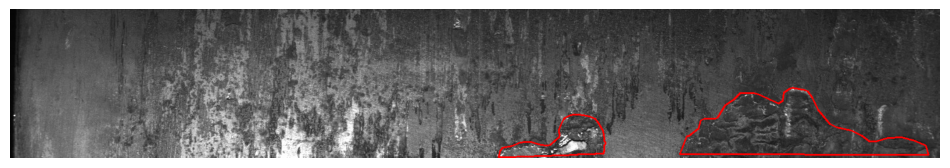

In [ ]:
from PIL import Image, ImageDraw

row_id=13

fname, onlyname, image, masks, class_labels = read_image_with_masks(row_id, train_df)
keypoints, class_labels = convert_masks_to_xy(masks, class_labels)

visualize(image, keypoints)

#img = Image.fromarray(image)#Image.open(fname)
#h,w = image.shape[:2]
#draw = ImageDraw.Draw(img)
#for polygon in keypoints:
#    draw.polygon(polygon,outline=(0,255,0), width=5)
#img

In [ ]:
from sklearn.model_selection import train_test_split

train_df_n, val_df_n = train_test_split(train_df, test_size=0.1, stratify=train_df["count"], random_state=54)
#train_df_n, val_df_n = train_test_split(train_df, test_size=0.9, stratify=train_df["count"], random_state=54)
#train_df_n, val_df_n = train_test_split(train_df_n, test_size=0.1, random_state=54)

print([len(train_df_n),len(val_df_n)])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[5999, 667]


In [ ]:
import cv2
from PIL import Image, ImageDraw
import albumentations as A

img_size = 640

train_transform = A.Compose([
    #A.CenterCrop(smallsize, smallsize),
    A.Resize(width=img_size, height=img_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.25, scale_limit=0.25, rotate_limit=45, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    #A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=0.3),
])

val_transform = A.Compose([
    #A.CenterCrop(smallsize, smallsize),
    A.Resize(width=img_size, height=img_size),
])

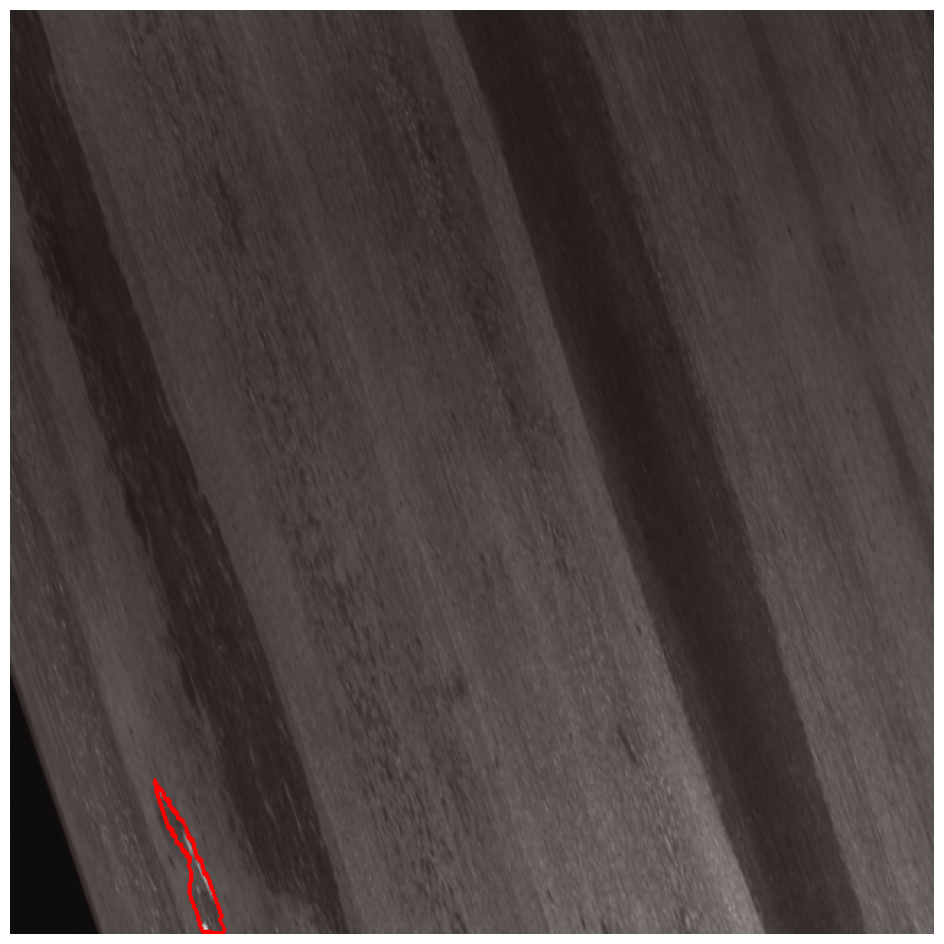

In [ ]:
import albumentations as A
import cv2

#row_id=train_df_n.index.get_loc('d0fb25531.jpg')
row_id=1

fname, onlyname, image, masks, class_labels = read_image_with_masks(row_id, train_df_n)

transformed = train_transform(image=image, masks=masks)
transformed_image = transformed['image']
transformed_masks = transformed['masks']

transformed_keypoints, transformed_class_labels = convert_masks_to_xy(transformed_masks, class_labels)

#print(transformed_keypoints)
visualize(transformed_image, transformed_keypoints)

In [ ]:
import os
import shutil

if os.path.isdir('images'):
    shutil.rmtree('images')
if os.path.isdir('labels'):
    shutil.rmtree('labels')

!mkdir images
!mkdir labels

!mkdir images/train
!mkdir images/val
#!mkdir test

!mkdir labels/train
!mkdir labels/val
#!mkdir test


In [ ]:
def transform_element(transformM, image, masks, class_labels, onlyname, outdir1, outdir2, img_size, ii=None):
    transformed = transformM(image=image, masks=masks, class_labels=class_labels)
    transformed_image = transformed['image']
    transformed_masks = transformed['masks']
    transformed_class_labels = transformed['class_labels']
    transformed_name = onlyname
    if ii:
        transformed_name += '_'+str(ii)
    nn=os.path.basename(os.path.normpath(transformed_name))
    cv2.imwrite(outdir1 + nn +'.jpg', cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR))
    out_file = open(outdir2 + nn +'.txt', 'w')

    transformed_keypoints, transformed_class_labels = convert_masks_to_xy(transformed_masks, transformed_class_labels)

    for iii in range(len(transformed_keypoints)):
        kOut=transformed_keypoints[iii]
        clOut=transformed_class_labels[iii]

        if(len(kOut)<6):
            continue

        #A.core.keypoints_utils.check_keypoints(kOut, img_size, img_size)
        text=str(clOut) + " " + " ".join([str(b) for b in kOut]) + '\n'
        out_file.write(text)
    out_file.close()

In [ ]:
outdir1 = "./images/train/"
outdir2 = "./labels/train/"

AUG_COUNT=5

for i in range(len(train_df_n)):
    fname, onlyname, image, masks, class_labels = read_image_with_masks(i,train_df_n)
    transform_element(val_transform, image, masks, class_labels, onlyname, outdir1, outdir2, img_size)

    for ii in range(AUG_COUNT):
        transform_element(train_transform, image, masks, class_labels, onlyname, outdir1, outdir2, img_size, ii)


In [ ]:
outdir1 = "./images/val/"
outdir2 = "./labels/val/"
for i in range(len(val_df_n)):
    fname, onlyname, image, masks, class_labels = read_image_with_masks(i,val_df_n)
    transform_element(val_transform, image, masks, class_labels, onlyname, outdir1, outdir2, img_size)

In [ ]:
f = open("./train.yaml", "w")
f.write('path: '+init_dir+"\n")
f.write('train: images/train'+"\n")
f.write('val: images/val'+"\n")
#f.write('test: images/test'+"\n")
#f.write('nc: 4'+"\n")
f.write('names:'+"\n")
f.write('  0: 0'+"\n")
f.write('  1: 1'+"\n")
f.write('  2: 2'+"\n")
f.write('  3: 3'+"\n")
f.write('  4: 4'+"\n")
f.close()

In [ ]:
a = """
# Ultralytics YOLO 🚀, AGPL-3.0 license
# YOLOv8-seg instance segmentation model. For Usage examples see https://docs.ultralytics.com/tasks/segment

# Parameters
nc: 5  # number of classes
scales: # model compound scaling constants, i.e. 'model=yolov8n-seg.yaml' will call yolov8-seg.yaml with scale 'n'
  # [depth, width, max_channels]
  n: [0.33, 0.25, 1024]
  s: [0.33, 0.50, 1024]
  m: [0.67, 0.75, 768]
  l: [1.00, 1.00, 512]
  x: [1.00, 1.25, 512]

# YOLOv8.0n backbone
backbone:
  # [from, repeats, module, args]
  - [-1, 1, Conv, [64, 3, 2]]  # 0-P1/2
  - [-1, 1, Conv, [128, 3, 2]]  # 1-P2/4
  - [-1, 3, C2f, [128, True]]
  - [-1, 1, Conv, [256, 3, 2]]  # 3-P3/8
  - [-1, 6, C2f, [256, True]]
  - [-1, 1, Conv, [512, 3, 2]]  # 5-P4/16
  - [-1, 6, C2f, [512, True]]
  - [-1, 1, Conv, [1024, 3, 2]]  # 7-P5/32
  - [-1, 3, C2f, [1024, True]]
  - [-1, 1, SPPF, [1024, 5]]  # 9

# YOLOv8.0n head
head:
  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 6], 1, Concat, [1]]  # cat backbone P4
  - [-1, 3, C2f, [512]]  # 12

  - [-1, 1, nn.Upsample, [None, 2, 'nearest']]
  - [[-1, 4], 1, Concat, [1]]  # cat backbone P3
  - [-1, 3, C2f, [256]]  # 15 (P3/8-small)

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 12], 1, Concat, [1]]  # cat head P4
  - [-1, 3, C2f, [512]]  # 18 (P4/16-medium)

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 9], 1, Concat, [1]]  # cat head P5
  - [-1, 3, C2f, [1024]]  # 21 (P5/32-large)

  - [[15, 18, 21], 1, Segment, [nc, 32, 256]]  # Segment(P3, P4, P5)"""

f = open("yolov8-seg.yaml", "w")
f.write(a)
f.close()

In [ ]:
!wandb off

W&B offline. Running your script from this directory will only write metadata locally. Use wandb disabled to completely turn off W&B.


In [ ]:
if os.path.isdir('./runs/segment/train'):
    shutil.rmtree('./runs/segment/train')

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov8n-seg.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
results = model.train(data='train.yaml', epochs=30, batch=32, pretrained=False)

Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.yaml, data=train.yaml, epochs=30, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscr

100%|██████████| 755k/755k [00:00<00:00, 86.9MB/s]
2023-12-16 06:11:59,379	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-16 06:11:59,847	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.



                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

wandb: Tracking run with wandb version 0.16.1
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 227MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 29995 images, 274 backgrounds, 0 corrupt: 100%|██████████| 29995/29995 [00:32<00:00, 927.22it/s] 


train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/labels/val... 667 images, 0 backgrounds, 0 corrupt: 100%|██████████| 667/667 [00:00<00:00, 1006.87it/s]


val: New cache created: /kaggle/working/labels/val.cache
Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.47G      3.525      5.156      4.153      3.621         56        640: 100%|██████████| 938/938 [10:12<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.53it/s]


                   all        667       2438      0.257     0.0292    0.00896    0.00247      0.257     0.0308    0.00738    0.00181

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       2/30       8.5G      2.423      3.316      2.795      2.298         81        640: 100%|██████████| 938/938 [10:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]


                   all        667       2438      0.363      0.134     0.0647      0.019       0.35      0.121     0.0494     0.0144

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       3/30      8.51G      2.076       3.13      2.474      1.945         80        640: 100%|██████████| 938/938 [10:02<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


                   all        667       2438      0.374     0.0819     0.0484     0.0157        0.4     0.0742     0.0449     0.0126

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.11G      1.956       3.02      2.341       1.78         49        640: 100%|██████████| 938/938 [10:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]


                   all        667       2438      0.422      0.201      0.115     0.0392      0.398      0.171     0.0883     0.0279

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.11G      1.855       2.91      2.223       1.69         58        640: 100%|██████████| 938/938 [10:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]


                   all        667       2438      0.487      0.204      0.162      0.062      0.475      0.189      0.147     0.0498

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       6/30      6.11G      1.806      2.854      2.157      1.646         56        640: 100%|██████████| 938/938 [10:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]


                   all        667       2438      0.474      0.199      0.151     0.0549      0.449      0.172      0.127     0.0381

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       7/30      6.11G      1.768      2.811      2.106      1.613         54        640: 100%|██████████| 938/938 [10:04<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.59it/s]


                   all        667       2438      0.537      0.236        0.2     0.0803      0.497      0.207      0.159     0.0543

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       8/30      6.11G       1.73      2.754      2.054      1.586         63        640: 100%|██████████| 938/938 [10:10<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

                   all        667       2438       0.53      0.253      0.225     0.0887      0.506      0.222      0.191     0.0654



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


       9/30       6.1G      1.705       2.73      2.022      1.569         28        640: 100%|██████████| 938/938 [10:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.57it/s]

                   all        667       2438      0.535      0.259      0.234     0.0934      0.523      0.232      0.197     0.0712



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      10/30       6.1G      1.684      2.702      1.986      1.549        106        640: 100%|██████████| 938/938 [10:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]

                   all        667       2438      0.543      0.269       0.25     0.0975      0.488      0.225      0.187     0.0672



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.11G      1.663      2.675      1.954      1.534         55        640: 100%|██████████| 938/938 [10:04<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.61it/s]


                   all        667       2438      0.587      0.269      0.254      0.106      0.537      0.233        0.2     0.0711

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.11G      1.648      2.654       1.93      1.521         85        640: 100%|██████████| 938/938 [10:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.55it/s]

                   all        667       2438      0.325      0.283      0.264      0.114      0.294      0.241      0.216     0.0808



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      13/30       6.1G      1.636      2.639      1.911      1.509         46        640: 100%|██████████| 938/938 [10:03<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.58it/s]

                   all        667       2438      0.578      0.296      0.275      0.114      0.527      0.245      0.214      0.076



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.11G      1.618      2.621      1.883      1.499         49        640: 100%|██████████| 938/938 [10:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        667       2438      0.335      0.301      0.283      0.122      0.292      0.259      0.226     0.0836



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      15/30       6.1G      1.613      2.603      1.861      1.492         63        640: 100%|██████████| 938/938 [10:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]

                   all        667       2438      0.439      0.319      0.294      0.125      0.286      0.267      0.228     0.0848



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      16/30       6.1G      1.602      2.586      1.844       1.48         33        640: 100%|██████████| 938/938 [10:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

                   all        667       2438      0.384      0.322      0.306      0.127      0.568      0.268      0.246     0.0894



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      17/30       6.1G      1.591       2.56      1.829      1.471         79        640: 100%|██████████| 938/938 [10:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


                   all        667       2438      0.592      0.324      0.302       0.13      0.552      0.263      0.238     0.0888

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      18/30       6.1G      1.586      2.564      1.818      1.471        112        640: 100%|██████████| 938/938 [10:08<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.56it/s]

                   all        667       2438      0.439      0.339      0.321       0.14      0.313      0.253       0.25     0.0933



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      19/30       6.1G      1.573      2.545      1.799      1.458         50        640: 100%|██████████| 938/938 [10:10<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.64it/s]

                   all        667       2438      0.404      0.358      0.312      0.138      0.293      0.274      0.242      0.091



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      20/30       6.1G      1.563      2.537      1.779      1.448         44        640: 100%|██████████| 938/938 [10:11<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

                   all        667       2438      0.389      0.369      0.324      0.144      0.323      0.292      0.251      0.094


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      21/30      8.72G      1.676      2.438      1.823      1.543         30        640: 100%|██████████| 938/938 [08:49<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.54it/s]

                   all        667       2438      0.399      0.356      0.319      0.141      0.324      0.274      0.257     0.0953



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.13G      1.661      2.421      1.788      1.532         46        640: 100%|██████████| 938/938 [08:44<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.63it/s]

                   all        667       2438      0.433      0.365      0.343      0.156      0.329      0.276       0.27      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.13G      1.647      2.405       1.76      1.523         43        640: 100%|██████████| 938/938 [08:44<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

                   all        667       2438      0.415      0.371      0.345      0.156      0.305      0.305      0.266      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.13G      1.632      2.392      1.739      1.515         29        640: 100%|██████████| 938/938 [08:46<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.49it/s]

                   all        667       2438      0.456      0.363      0.348      0.157      0.362      0.305      0.278      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.12G       1.62      2.374      1.715      1.505         34        640: 100%|██████████| 938/938 [08:45<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.71it/s]

                   all        667       2438      0.443      0.349      0.347      0.158      0.361       0.29      0.276      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.13G      1.604      2.356      1.699      1.495         40        640: 100%|██████████| 938/938 [08:45<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.67it/s]

                   all        667       2438      0.465      0.358      0.356      0.159      0.338      0.283      0.269      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.13G      1.594      2.341       1.68       1.49         56        640: 100%|██████████| 938/938 [08:46<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:07<00:00,  1.43it/s]

                   all        667       2438      0.464      0.357      0.357       0.16       0.33      0.285      0.272      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.13G      1.583      2.324      1.658      1.483         66        640: 100%|██████████| 938/938 [08:46<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.70it/s]

                   all        667       2438      0.483      0.363      0.355       0.16       0.35      0.294      0.273      0.105



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.12G       1.57      2.307      1.634      1.472         27        640: 100%|██████████| 938/938 [08:45<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.57it/s]

                   all        667       2438      0.506      0.351      0.358       0.16      0.366      0.286      0.279      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.13G      1.555      2.285      1.613      1.467         46        640: 100%|██████████| 938/938 [08:44<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:06<00:00,  1.72it/s]

                   all        667       2438      0.467      0.355      0.356      0.159      0.354      0.298      0.284      0.108



30 epochs completed in 4.899 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.227 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
YOLOv8n-seg summary (fused): 195 layers, 3259039 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


                   all        667       2438      0.468      0.355      0.356      0.159      0.356      0.297      0.284      0.108
                     0        667        365      0.485       0.43      0.433      0.171      0.384      0.342      0.307       0.11
                     1        667         45      0.324     0.0889      0.108     0.0296     0.0803     0.0222     0.0631     0.0125
                     2        667       1840      0.509      0.423      0.409      0.175       0.44      0.367       0.33       0.13
                     3        667        188      0.553      0.479      0.474      0.261       0.52      0.456      0.437       0.18
Speed: 0.9ms preprocess, 3.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg1 ▃▆███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
wandb:                  lr/pg2 ▃▆███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
wandb:        metrics/mAP50(B) ▁▂▂▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████████
wandb:        metrics/mAP50(M) ▁▂▂▃▅▄▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
wandb:     metrics/mAP50-95(B) ▁▂▂▃▄▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████████
wandb:     metrics/mAP50-95(M) ▁▂▂▃▄▃▄▅▆▅▆▆▆▆▆▇▇▇▇▇▇█████████
wandb:    metrics/precision(B) ▁▃▃▄▆▆▇▇▇▇█▂█▃▅▄█▅▄▄▄▅▄▅▅▅▅▆▆▅
wandb:    metrics/precision(M) ▁▃▄▄▆▅▆▇▇▆▇▂▇▂▂██▂▂▂▃▃▂▃▃▃▃▃▃▃
wandb:       metrics/recall(B) ▁▃▂▅▅▄▅▆▆▆▆▆▆▇▇▇▇▇████████████
wandb:       metrics/recall(M) ▁▃▂▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇▇███▇▇███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▄▃▃▃▃▂▂▂▂▂

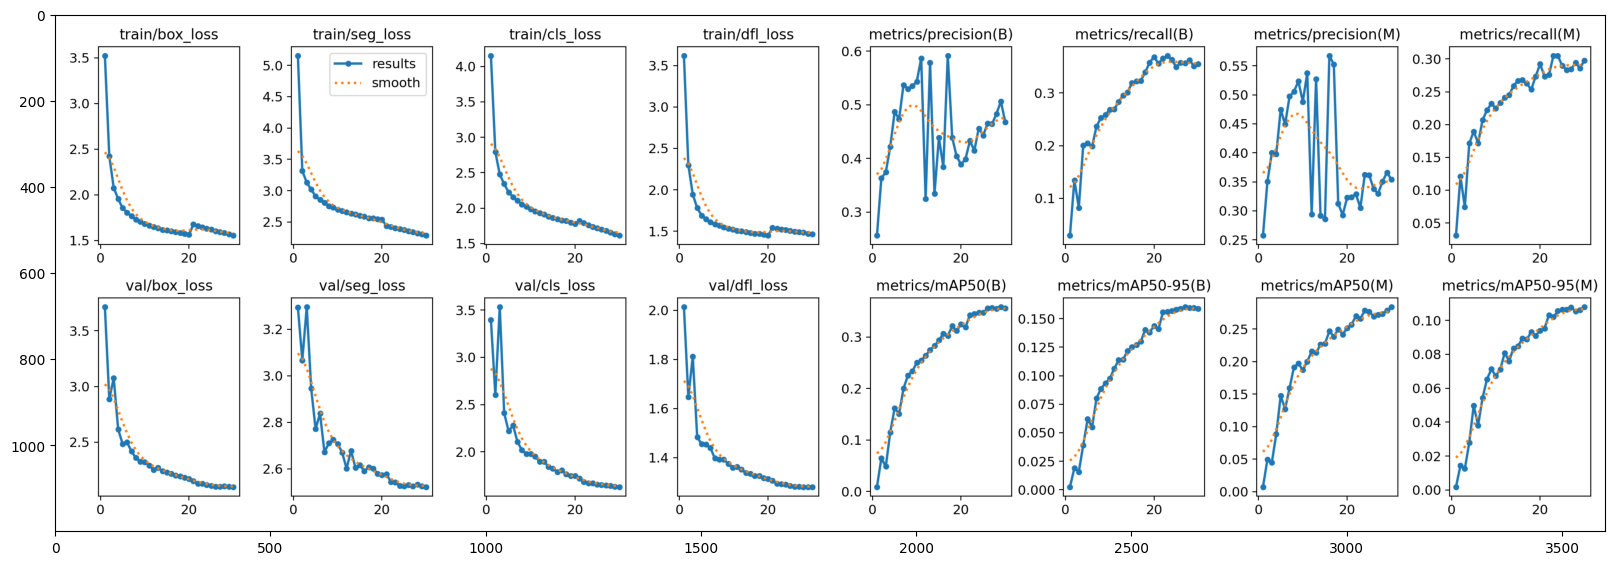

In [ ]:
image = np.array(Image.open('./runs/segment/train/results.png'))
plt.figure(figsize=(20, 20))
plt.imshow(image)

In [ ]:
#https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
import glob

img_names = sorted(glob.glob(TEST_IMAGE_DATASET_PATH + "/*.jpg"))

In [ ]:
import torch
from ultralytics import YOLO

model = YOLO('./runs/segment/train/weights/last.pt')


image 1/1 /kaggle/input/severstal-steel-defect-detection/test_images/00513039a.jpg: 128x640 1 2, 73.2ms
Speed: 1.0ms preprocess, 73.2ms inference, 3.7ms postprocess per image at shape (1, 3, 128, 640)


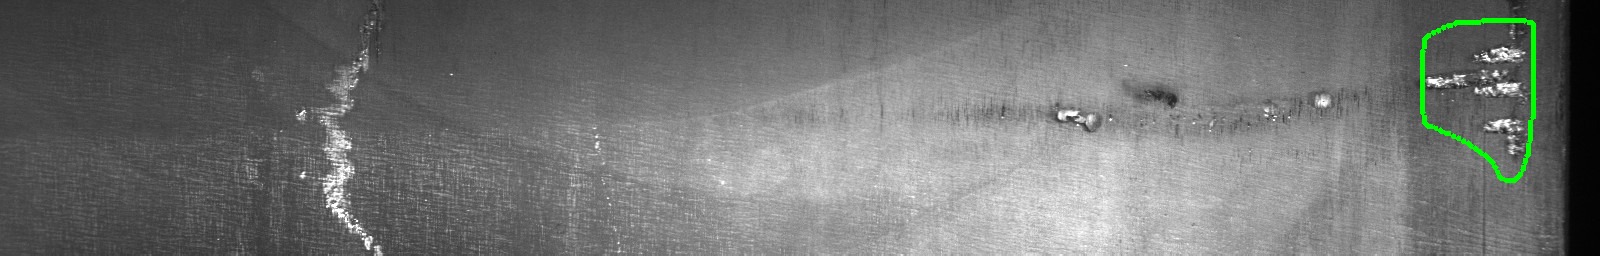

In [ ]:
test_img = img_names[6]
img = Image.open(test_img)
draw = ImageDraw.Draw(img)

pred_results = model(test_img)

if(pred_results[0].masks):
    masks = pred_results[0].masks.cpu()
    for mask in masks:
        #maskt = mask.data[0].numpy()
        for polygon in mask.xy:
            #mask_img = Image.fromarray(maskt,"I")
            draw.polygon(polygon,outline=(0,255,0), width=5)
img